In [1]:
import re
import os
import sys
import time
import itertools
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
import multiprocessing
from numpy.linalg import *
from scipy.linalg import *
from scipy.io import loadmat
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from typing import List, Union, Tuple
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.algorithm.compiler import *
from scipy.sparse import csc_matrix, csr_matrix
from mindquantum.simulator.utils import GradOpsWrapper
from mindquantum.simulator import Simulator, get_supported_simulator

np.set_printoptions(linewidth=1000)

c:\Program Files\Python39\lib\site-packages\mindquantum\simulator\__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (c:\Program Files\Python39\lib\site-packages\mindquantum\__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR
c:\Program Files\Python39\lib\site-packages\mindquantum\__init__.py:57: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import (


In [ ]:
def Rd(name, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'R{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'R{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= 3:
        raise ValueError(f'R{name} index {ind} should in 0 to 2')
    mat = np.eye(3, dtype=CDTYPE)
    if 'X' in name:
        mat[np.ix_(ind, ind)] = RX(pr).matrix()
    elif 'Y' in name:
        mat[np.ix_(ind, ind)] = RY(pr).matrix()
    elif 'Z' in name:
        mat[np.ix_(ind, ind)] = RZ(pr).matrix()
    return mat


def GCR(name, ind, pr, state, reverse=False):
    if state < 0 or state >= 3:
        raise ValueError(f'¦{state}⟩ control state should in 0 to 2')
    if reverse:
        mat = np.eye(9, dtype=CDTYPE)
        idx = [i for i in range(9) if i % 3 == state]
        mat[np.ix_(idx, idx)] = Rd(name, ind, pr)
    else:
        mat = block_diag(np.eye(3 * state), Rd(name, ind, pr), np.eye(3 * (2 - state)))
    return mat


def Pm(pr, state):
    return block_diag(np.eye(state), np.exp(1j * pr), np.eye(2 - state))


state = 0
pr = [1, 2, 3]
mat = np.kron(Pm(pr[2], state), np.eye(3)) @ GCR('Z', [0, 2], pr[1], state) @ GCR('Z', [0, 1], pr[0], state)
print(mat)

p = np.eye(16) - symmetric_encoding(np.eye(9), 2)
print(symmetric_encoding(mat, 2) + p)

[[ 0.0707372 +0.99749499j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.93645669-0.35078323j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.65364362-0.7568025j   0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          1.        +0.j          0

[[ 0.0707372 +0.99749499j -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j        ]
 [-0.        +0.j         -0.96322459-0.10483161j  0.0267679 -0.24595162j -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j        ]
 [-0.        +0.j          0.0267679 -0.24595162j -0.96322459-0.10483161j -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j         -0.     

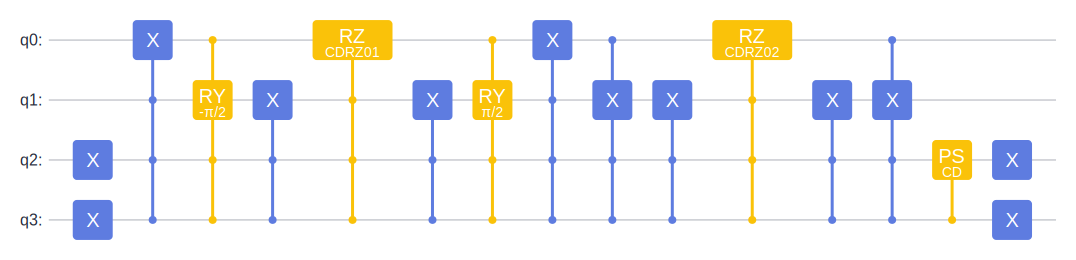

In [81]:
circ = controlled_diagonal_synthesis(3, 'CD', 0, [1, 2, 3], state)
print(circ.matrix(pr))
# circ.ansatz_params_name
circ.svg()

In [ ]:
mat = np.kron(Pm(pr[2], state), np.eye(3))
print(mat)

p = np.eye(16) - symmetric_encoding(np.eye(9), 2)
print(symmetric_encoding(mat, 2) + p)

[[-0.9899925+0.14112001j -0.       +0.j         -0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [-0.       +0.j         -0.9899925+0.14112001j -0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [-0.       +0.j         -0.       +0.j         -0.9899925+0.14112001j  0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j          0.       +0.j          0.       +0.j      

[[-0.9899925+0.14112001j -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j        ]
 [-0.       +0.j         -0.9899925+0.14112001j -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j        ]
 [-0.       +0.j         -0.       +0.j         -0.9899925+0.14112001j -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.       +0.j         -0.

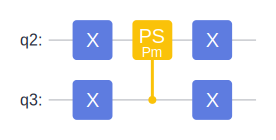

In [89]:
def Pm_synthesis(name: str, ctrl: List[int], state: int) -> Circuit:
    if state == 0:
        corr = Circuit() + X(ctrl[1]) + X(ctrl[2])
    elif state == 1:
        corr = Circuit() + X(ctrl[1], ctrl[2]) + RY(np.pi / 2).on(ctrl[2])
    elif state == 2:
        corr = Circuit()
    circ = Circuit() + corr
    circ += PhaseShift(name).on(ctrl[1], ctrl[2])
    circ += corr.hermitian()
    return circ


circ = Pm_synthesis('Pm', [1, 2, 3], 0)
print(circ.matrix(pr[2]))
circ.svg()

In [18]:
dim, n_qudits = 3, 1
n_qubits = (dim - 1) * n_qudits
p = np.eye(2**n_qubits) - symmetric_encoding(np.eye(dim), n_qudits)

i, j = 0, 1
mat1 = np.eye(dim, dtype=np.complex128)
mat1[np.ix_([i, j], [i, j])] = np.array([[1, 2], [3, 4]])
mat2 = symmetric_encoding(mat1, n_qudits) + p
print(mat1)
print(mat2)

[[1.+0.j 2.+0.j 0.+0.j]
 [3.+0.j 4.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j]]
[[1.        +0.j 1.41421356+0.j 1.41421356+0.j 0.        +0.j]
 [2.12132034+0.j 2.5       +0.j 1.5       +0.j 0.        +0.j]
 [2.12132034+0.j 1.5       +0.j 2.5       +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 1.        +0.j]]


In [ ]:
def optimization(init_params: np.ndarray, sim_grad: GradOpsWrapper, loss_list: List[float] = None):
    f, g = sim_grad(init_params)
    loss = 1 - np.real(f)[0][0]
    grad = -np.real(g)[0][0]
    if loss_list is not None:
        loss_list.append(loss)
    return loss, grad


for r in range(1, 1000):
    3 = 3  # dimension of qudit state
    p = np.eye(16) - symmetric_encoding(np.eye(9), 2)
    mat = unitary_group.rvs(9)
    mat = symmetric_encoding(mat, 2) + p
    state = np.random.rand(9) + 1j * np.random.rand(9)
    state /= norm(state)

    obj = [0, 1, 2, 3]
    obj = obj[::-1]
    gate = UnivMathGate('mat', mat).on(obj)
    ansatz = qutrit_symmetric_ansatz(gate)

    nq = ansatz.n_qubits
    p_name = ansatz.ansatz_params_name
    p_num = len(p_name)
    g_num = sum(1 for _ in ansatz)
    depth = circuit_depth(ansatz)

    sim_list = set([i[0] for i in get_supported_simulator()])
    if 'mqvector_gpu' in sim_list and nq > 14:
        sim = Simulator('mqvector_gpu', nq)
        method = 'BFGS'
    else:
        sim = Simulator('mqvector', nq)
        method = 'BFGS'  # TNC CG

    psi = symmetric_encoding(state, 2, is_csr=True)  # encode qutrit state to qubit
    rho = psi.dot(psi.conj().T)  # rho & psi are both csr_matrix
    Ham = Hamiltonian(rho)  # set target state as Hamiltonian

    start = time.perf_counter()
    sim.reset()  # reset simulator to zero state
    sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
    while True:
        try:
            local_minima1, local_minima2 = [], []
            solver_options = {'gtol': 1e-20, 'maxiter': 1000}
            init_params = np.random.uniform(-np.pi, np.pi, p_num)
            res = minimize(optimization, init_params, (sim_grad, []), method, jac=True, options=solver_options)
            break
        except StopIteration:
            break  # reach loss tolerance
        except StopAsyncIteration:
            continue  # reach local minima
    end = time.perf_counter()
    seconds = round(end - start, 2)
    sim.reset()  # reset simulator to zero state
    pr_res = dict(zip(p_name, res.x))  # optimal result parameters
    sim.apply_circuit(ansatz.apply_value(pr_res))  # apply result params to circuit
    psi_res = sim.get_qs()  # get result pure state

    if not np.allclose(fidelity(psi_res, psi.toarray()), 1):
        print(f'{res.message}\nOptimal: {res.fun}, Fidelity: {1-res.fun:.20f} {res.nfev} {seconds}')
        print(fidelity(psi_res, psi.toarray()))

In [ ]:
def Rd(d, name, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'R{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'R{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'R{name} index {ind} should in 0 to {d-1}')
    mat = np.eye(d, dtype=CDTYPE)
    if 'RX' in name:
        mat[np.ix_(ind, ind)] = RX(pr).matrix()
    elif 'RY' in name:
        mat[np.ix_(ind, ind)] = RY(pr).matrix()
    elif 'RZ' in name:
        mat[np.ix_(ind, ind)] = RZ(pr).matrix()
    return mat


def GCR(d, name, ind, pr, state, reverse=False):
    if state < 0 or state >= d:
        raise ValueError(f'¦{state}⟩ control state should in 0 to {d-1}')
    if reverse:
        mat = np.eye(d**2, dtype=CDTYPE)
        idx = [i for i in range(d**2) if i % d == state]
        mat[np.ix_(idx, idx)] = Rd(d, name, ind, pr)
    else:
        mat = block_diag(np.eye(d * state), Rd(d, name, ind, pr), np.eye(d * (d - state - 1)))
    return mat


def Sm(d, pr, state):
    return block_diag(np.eye(state), np.exp(1j * pr), np.eye(d - 1 - state))


def Sm_synthesis(d: int, name: str, obj: int, ctrl: List[int], state: int) -> Circuit:
    if d != 3:
        raise ValueError('Only works when d = 3')
    if state == 0:
        corr = Circuit() + X(ctrl[1]) + X(ctrl[2])
    elif state == 1:
        corr = Circuit() + X(ctrl[2], ctrl[1]) + RY(np.pi / 2).on(ctrl[1])
    elif state == 2:
        corr = Circuit()
    circ = Circuit() + corr
    circ += PhaseShift(name).on(ctrl[2], ctrl[1])
    circ += corr.hermitian()
    return circ


def controlled_diagonal_synthesis(d: int, name: str, obj: int, ctrl: List[int], state: int) -> Circuit:
    if d != 3:
        raise ValueError('Only works when d = 3')
    if state == 0:
        corr = Circuit() + X(ctrl[1]) + X(ctrl[2])
    elif state == 1:
        corr = Circuit() + X(ctrl[1], ctrl[2]) + RY(np.pi / 2).on(ctrl[2])
    elif state == 2:
        corr = Circuit()
    ind01 = Circuit() + X(obj, ctrl) + RY(-np.pi / 2).on(ctrl[0], [obj] + ctrl[1:]) + X(ctrl[0], ctrl[1:])
    ind02 = Circuit() + X(ctrl[0], ctrl[1:] + [obj]) + X(ctrl[0], ctrl[1:])
    ind12 = Circuit() + X(obj, ctrl) + RY(np.pi / 2).on(ctrl[0], [obj] + ctrl[1:]) + X(obj, ctrl[1:])
    circ = Circuit() + corr
    circ = circ + ind01 + RZ(f'{name}RZ01').on(obj, ctrl) + ind01.hermitian()
    circ = circ + ind02 + RZ(f'{name}RZ02').on(obj, ctrl) + ind02.hermitian()
    circ += PhaseShift(name).on(ctrl[2], ctrl[1])
    # circ = circ + ind01 + GlobalPhase(f'{name}GP').on(obj, ctrl) + ind01.hermitian()
    # circ = circ + ind02 + GlobalPhase(f'{name}GP').on(obj, ctrl) + ind02.hermitian()
    # circ = circ + ind12 + GlobalPhase(f'{name}GP').on(obj, ctrl) + ind12.hermitian()
    circ += corr.hermitian()
    return circ

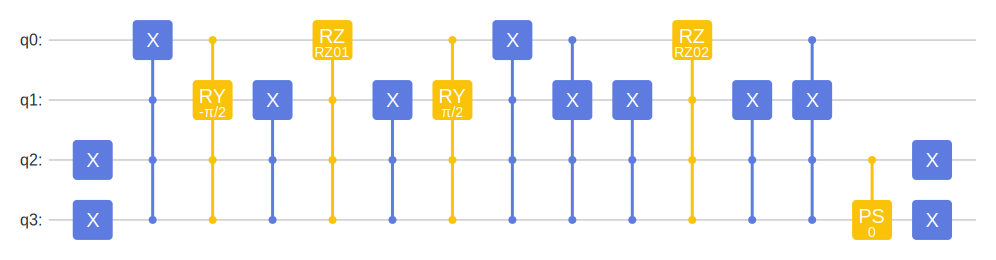

In [ ]:
for i in range(1000):
    3, obj, ctrl, state = 3, 0, [1, 2, 3], i % 3
    pr = np.random.rand(3)
    circ = controlled_diagonal_synthesis(3, '', obj, ctrl, state)
    nq = circ.n_qubits

    p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
    p1 = np.eye(2**(3 - 1)) - symmetric_encoding(np.eye(3))

    # CD = GCR(d, 'RZ02', [0, 2], pr[1], state) @ GCR(d, 'RZ01', [0, 1], pr[0], state)
    # CD = symmetric_encoding(CD, 2) + p
    # CD = np.kron(symmetric_encoding(Sm(d, pr[2], state)) + p1, np.eye(4)) @ CD

    CD = np.kron(Sm(3, pr[2], state), np.eye(3)) @ GCR(3, 'RZ02', [0, 2], pr[1], state) @ GCR(3, 'RZ01', [0, 1], pr[0], state)
    CD = symmetric_encoding(CD, 2) + p

    a1 = np.random.rand(3) + 1j * np.random.rand(3)
    a2 = np.random.rand(3) + 1j * np.random.rand(3)
    a1 /= norm(a1)
    a2 /= norm(a2)
    b1 = np.kron(a1, a2)
    b2 = symmetric_encoding(b1, 2)

    sim = Simulator('mqvector', nq)
    sim.set_qs(b2)
    sim.apply_circuit(circ, pr)
    if not np.allclose(sim.get_qs(), CD @ b2):
        print(sim.get_qs())
        print(CD @ b2)
        print(approx_matrix(sim.get_qs() - CD @ b2))
circ.svg()

In [ ]:
def Pd(name, d, ind):
    if len(ind) != 2:
        raise ValueError(f'{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'{name} index {ind} should in 0 to {d-1}')
    mat = np.eye(d, dtype=CDTYPE)
    if name == 'X':
        mat[np.ix_(ind, ind)] = X.matrix()
    elif name == 'Y':
        mat[np.ix_(ind, ind)] = Y.matrix()
    elif name == 'Z':
        mat[np.ix_(ind, ind)] = Z.matrix()
    return mat


def Rd(name, d, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'R{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'R{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'R{name} index {ind} should in 0 to {d-1}')
    mat = np.eye(d, dtype=CDTYPE)
    if name == 'X':
        mat[np.ix_(ind, ind)] = RX(pr).matrix()
    elif name == 'Y':
        mat[np.ix_(ind, ind)] = RY(pr).matrix()
    elif name == 'Z':
        mat[np.ix_(ind, ind)] = RZ(pr).matrix()
    return mat


def Ud(d, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'U3 index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'U3 index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'U3 index {ind} should in 0 to {d-1}')
    if len(pr) != 3:
        raise ValueError(f'U3 params length {len(pr)} should be 3')
    theta, phi, lam = pr
    mat = np.eye(d, dtype=CDTYPE)
    mat[np.ix_(ind, ind)] = U3(theta, phi, lam).matrix()
    return mat


def INC(d):
    mat = np.eye(d, dtype=CDTYPE)
    mat = mat[[d - 1] + list(range(d - 1))]
    return mat


def CINC(d):
    return block_diag(np.eye(d**2 - d), INC(d))


def GCX(d, ind, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Pd('X', d, ind), np.eye(d * (d - m - 1)))

def GCP(name, d, ind, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Pd(name, d, ind), np.eye(d * (d - m - 1)))

def GCR(name, d, ind, pr, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Rd(name, d, ind, pr), np.eye(d * (d - m - 1)))

def GCU(d, ind, U, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    mat = np.eye(d, dtype=CDTYPE)
    mat[np.ix_(ind, ind)] = U
    return block_diag(np.eye(d * m), mat, np.eye(d * (d - m - 1)))

In [ ]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


def Uind(basis, d, ind, pr, obj):
    if d != 3:
        raise ValueError('Only works when d = 3')
    if len(ind) != 2:
        raise ValueError(f'U3 index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'U3 index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'U3 index {ind} should in 0 to {d-1}')
    if len(pr) != 3:
        raise ValueError(f'U3 params length {len(pr)} should be 3')
    circ = Circuit()
    if ind == [0, 1]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(obj[1])
    elif ind == [0, 2]:
        corr = Circuit() + X(obj[0]) + X(obj[1], obj[0]) + X(obj[0])
    elif ind == [1, 2]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(-np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0])
    circ += corr
    if basis == 'zyz':
        circ += RZ(pr[0]).on(obj[0], obj[1])
        circ += RY(pr[1]).on(obj[0], obj[1])
        circ += RZ(pr[2]).on(obj[0], obj[1])
    elif basis == 'u3':
        theta, phi, lam = pr
        circ += U3(theta, phi, lam).on(obj[0], obj[1])
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    circ += corr.hermitian()
    return circ


def Ub(basis, d, name, obj):
    circ = Circuit()
    index = [[0, 2], [1, 2], [0, 2]]
    if basis == 'zyz':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}RZ{str_pr}', f'{name}RY{str_pr}', f'{name}Rz{str_pr}']
            circ += Uind(basis, d, ind, pr, obj)
    elif basis == 'u3':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}𝜃{str_pr}', f'{name}𝜑{str_pr}', f'{name}𝜆{str_pr}']
            circ += Uind(basis, d, ind, pr, obj)
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    return circ


def GCRb(d, ind, name, obj, ctrl, state):
    if d != 3:
        raise ValueError('Only works when d = 3')
    circ = Circuit()
    if state == 0:
        if ind == [0, 1]:
            corr = Circuit() + X(ctrl[1]) + X(ctrl[2]) + X(ctrl[0], ctrl[1:] + [obj]) + RY(np.pi / 2).on(obj, ctrl) + X(
                ctrl[0], ctrl[1:] + [obj]) + X(ctrl[0], ctrl[1:])
        elif ind == [0, 2]:
            corr = Circuit() + X(ctrl[1]) + X(ctrl[2]) + X(obj, ctrl[1:]) + X(ctrl[0], ctrl[1:] + [obj]) + X(
                obj, ctrl[1:])
        elif ind == [1, 2]:
            corr = Circuit() + X(ctrl[1]) + X(ctrl[2]) + X(ctrl[0], ctrl[1:] + [obj]) + RY(-np.pi / 2).on(
                obj, ctrl) + X(ctrl[0], ctrl[1:] + [obj])
    elif state == 1:
        if ind == [0, 1]:
            corr = Circuit() + X(ctrl[1], ctrl[2]) + RY(np.pi / 2).on(ctrl[2]) + X(ctrl[0], ctrl[1:] + [obj]) + RY(
                np.pi / 2).on(obj, ctrl) + X(ctrl[0], ctrl[1:] + [obj]) + X(ctrl[0], ctrl[1:])
        elif ind == [0, 2]:
            corr = Circuit() + X(ctrl[1], ctrl[2]) + RY(np.pi / 2).on(ctrl[2]) + X(obj, ctrl[1:]) + X(
                ctrl[0], ctrl[1:] + [obj]) + X(obj, ctrl[1:])
        elif ind == [1, 2]:
            corr = Circuit() + X(ctrl[1], ctrl[2]) + RY(np.pi / 2).on(ctrl[2]) + X(ctrl[0], ctrl[1:] + [obj]) + RY(
                -np.pi / 2).on(obj, ctrl) + X(ctrl[0], ctrl[1:] + [obj])
    elif state == 2:
        if ind == [0, 1]:
            corr = Circuit() + X(ctrl[0], ctrl[1:] + [obj]) + RY(np.pi / 2).on(obj, ctrl) + X(
                ctrl[0], ctrl[1:] + [obj]) + X(ctrl[0], ctrl[1:])
        elif ind == [0, 2]:
            corr = Circuit() + X(obj, ctrl[1:]) + X(ctrl[0], ctrl[1:] + [obj]) + X(obj, ctrl[1:])
        elif ind == [1, 2]:
            corr = Circuit() + X(ctrl[0], ctrl[1:] + [obj]) + RY(-np.pi / 2).on(obj, ctrl) + X(
                ctrl[0], ctrl[1:] + [obj])
    circ += corr
    if 'RX' in name:
        circ = circ + RX(name).on(obj, ctrl)
    elif 'RY' in name:
        circ = circ + RY(name).on(obj, ctrl)
    elif 'RZ' in name:
        circ = circ + RZ(name).on(obj, ctrl)
    elif 'GP' in name:
        circ = circ + GlobalPhase(name).on(obj, ctrl)
    circ += corr.hermitian()
    return circ


def GCPb(d, name, obj, ctrl, state):
    if d != 3:
        raise ValueError('Only works when d = 3')
    circ = Circuit()
    if state == 0:
        corr = Circuit()
    elif state == 1:
        corr = Circuit()
    elif state == 2:
        corr = Circuit()
    circ += corr
    circ = circ + GlobalPhase(name).on(obj, ctrl)
    circ += corr.hermitian()
    return circ


def Cb(d, name, obj, ctrl, state):
    if d != 3:
        raise ValueError('Only works when d = 3')
    circ = Circuit()
    circ += GCRb(d, [0, 1], f'{name}RZ01', obj, ctrl, state)
    circ += GCRb(d, [0, 2], f'{name}RZ02', obj, ctrl, state)
    circ += GCRb(d, [0, 1], f'{name}GP', obj, ctrl, state)
    circ += GCRb(d, [0, 2], f'{name}GP', obj, ctrl, state)
    circ += GCRb(d, [1, 2], f'{name}GP', obj, ctrl, state)
    return circ


def qutrit_symmetric_ansatz(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = False):
    name = f'{gate.name}_'
    obj = gate.obj_qubits
    circ = Circuit()
    if len(obj) == 2:
        circ += Ub(basis, 3, f'{name}', obj)
    elif len(obj) == 4:
        circ += Ub(basis, 3, f'{name}U1_', obj[:2])
        circ += Cb(3, f'{name}C1_', obj[0], obj[1:], 1)
        circ += Ub(basis, 3, f'{name}U2_', obj[:2])
        circ += Cb(3, f'{name}C2_', obj[0], obj[1:], 2)
        circ += Ub(basis, 3, f'{name}U3_', obj[:2])
        circ += GCRb(3, [1, 2], f'{name}RY12', obj[-1], obj[::-1][1:], 2)
        circ += GCRb(3, [1, 2], f'{name}RY11', obj[-1], obj[::-1][1:], 1)
        circ += GCRb(3, [1, 2], f'{name}RY10', obj[-1], obj[::-1][1:], 0)
        circ += Ub(basis, 3, f'{name}U4_', obj[:2])
        circ += Cb(3, f'{name}C3_', obj[0], obj[1:], 2)
        circ += Ub(basis, 3, f'{name}U5_', obj[:2])
        circ += GCRb(3, [0, 1], f'{name}RY22', obj[-1], obj[::-1][1:], 2)
        circ += GCRb(3, [0, 1], f'{name}RY21', obj[-1], obj[::-1][1:], 1)
        circ += GCRb(3, [0, 1], f'{name}RY20', obj[-1], obj[::-1][1:], 0)
        circ += Ub(basis, 3, f'{name}U6_', obj[:2])
        circ += Cb(3, f'{name}C4_', obj[0], obj[1:], 0)
        circ += Ub(basis, 3, f'{name}U7_', obj[:2])
        circ += GCRb(3, [1, 2], f'{name}RY32', obj[-1], obj[::-1][1:], 2)
        circ += GCRb(3, [1, 2], f'{name}RY31', obj[-1], obj[::-1][1:], 1)
        circ += GCRb(3, [1, 2], f'{name}RY30', obj[-1], obj[::-1][1:], 0)
        circ += Ub(basis, 3, f'{name}U8_', obj[:2])
        circ += Cb(3, f'{name}C5_', obj[0], obj[1:], 2)
        circ += Ub(basis, 3, f'{name}U9_', obj[:2])
    else:
        raise ValueError('Only works when number of qutrits <= 2')
    if with_phase:
        for i in obj:
            circ += GlobalPhase(f'{name}phase').on(i)
    return circ


opt_basis = ['zyz', 'u3']

3, state = 3, 2
nqd = (3 - 1) * state
Id = symmetric_encoding(np.eye(3**state), state)
p = np.eye(Id.shape[0]) - Id

circ = Circuit()
ansatz = Circuit()
mat = unitary_group.rvs(3**state)
mat = symmetric_encoding(mat, state) + p
gate = UnivMathGate(f'mat', mat).on(list(range(nqd)))
circ += gate
ansatz += qutrit_symmetric_ansatz(gate, 'zyz')

nqd = circ.n_qubits
sim = Simulator('mqvector', nqd)
sim.apply_circuit(circ)
psi = sim.get_qs()

rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))
print('Hamiltonian Dimension:', rho.shape)

p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nqd)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
start = time.perf_counter()
fun(p0, sim_grad)
res = minimize(fun, p0, args=(sim_grad, []), method='CG', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))
print('Is state symmetric:', is_symmetric(psi, state), is_symmetric(psi_res, state))

ansatz.svg()

Hamiltonian Dimension: (16, 16)
Number of qubits: 4
Number of params: 105
Number of gates: 571
Loss: 0.596544294511856, Fidelity: 0.403455705488144,  10, 0.0320
Loss: 0.304706879076848, Fidelity: 0.695293120923152,  20, 0.0567
Loss: 0.104836900825776, Fidelity: 0.895163099174224,  30, 0.0748
Loss: 0.042021750402695, Fidelity: 0.957978249597305,  40, 0.0868
Loss: 0.013105811861826, Fidelity: 0.986894188138174,  50, 0.0990
Loss: 0.003389954804353, Fidelity: 0.996610045195647,  60, 0.1107
Loss: 0.000719291316225, Fidelity: 0.999280708683775,  70, 0.1215
Loss: 0.000029717622746, Fidelity: 0.999970282377254,  80, 0.1324
Loss: 0.000008830973676, Fidelity: 0.999991169026324,  90, 0.1441
Loss: 0.000000475392708, Fidelity: 0.999999524607292, 100, 0.1562
Loss: 0.000000062171216, Fidelity: 0.999999937828784, 110, 0.1665
Loss: 0.000000007793966, Fidelity: 0.999999992206034, 120, 0.1793
Loss: 0.000000001567076, Fidelity: 0.999999998432924, 130, 0.1911
Loss: 0.000000000756232, Fidelity: 0.9999999992

Hamiltonian Dimension: (16, 16)
Number of qubits: 4
Number of params: 18
Number of gates: 54
Loss: 0.558253666085117, Fidelity: 0.441746333914883,  10, 0.0022
Loss: 0.048818663925498, Fidelity: 0.951181336074502,  20, 0.0042
Loss: 0.000000015945546, Fidelity: 0.999999984054454,  30, 0.0063
Loss: 0.000000000000019, Fidelity: 0.999999999999981,  40, 0.0085
Loss: 0.000000000000000, Fidelity: 1.000000000000000,  50, 0.0111
Loss: 0.000000000000001, Fidelity: 0.999999999999999,  60, 0.0135
Desired error not necessarily achieved due to precision loss.
Optimal: 0.00000000000000011102
psi norm: 1.98673029581934357246
psi fidelity: 1.00000000000000000000
Is state symmetric: True True


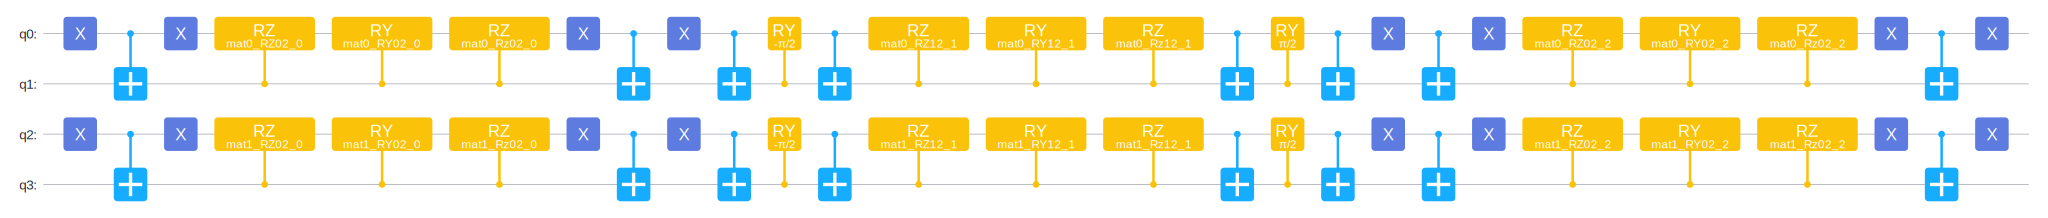

In [ ]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


def Ub(basis, d, ind, pr, obj):
    if d != 3:
        raise ValueError('Only works when d = 3')
    if len(ind) != 2:
        raise ValueError(f'U3 index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'U3 index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'U3 index {ind} should in 0 to {d-1}')
    if len(pr) != 3:
        raise ValueError(f'U3 params length {len(pr)} should be 3')
    circ = Circuit()
    if ind == [0, 1]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(obj[1])
    elif ind == [0, 2]:
        corr = Circuit() + X(obj[0]) + X(obj[1], obj[0]) + X(obj[0])
    elif ind == [1, 2]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(-np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0])
    circ += corr
    if basis == 'zyz':
        circ += RZ(pr[0]).on(obj[0], obj[1])
        circ += RY(pr[1]).on(obj[0], obj[1])
        circ += RZ(pr[2]).on(obj[0], obj[1])
    elif basis == 'u3':
        theta, phi, lam = pr
        circ += U3(theta, phi, lam).on(obj[0], obj[1])
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    circ += corr.hermitian()
    return circ


def one_qutrit_symmetric_ansatz(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = False):
    name = f'{gate.name}_'
    obj = gate.obj_qubits
    circ = Circuit()
    index = [[0, 2], [1, 2], [0, 2]]
    if basis == 'zyz':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}RZ{str_pr}', f'{name}RY{str_pr}', f'{name}Rz{str_pr}']
            circ += Ub(basis, 3, ind, pr, obj)
    elif basis == 'u3':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}𝜃{str_pr}', f'{name}𝜑{str_pr}', f'{name}𝜆{str_pr}']
            circ += Ub(basis, 3, ind, pr, obj)
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    if with_phase:
        for i in obj:
            circ += GlobalPhase(f'phase').on(i)
    return circ


opt_basis = ['zyz', 'u3']

3, state = 3, 2
nqd = 3 - 1
Id = symmetric_encoding(np.eye(3))
p = np.eye(Id.shape[0]) - Id

mat = {}
circ = Circuit()
ansatz = Circuit()
for i in range(state):
    mat[i] = unitary_group.rvs(3)
    mat[i + state] = symmetric_encoding(mat[i]) + p
    ctrl = list(range(nqd * i, nqd * (i + 1)))
    gate = UnivMathGate(f'mat{i}', mat[i + state]).on(ctrl)
    circ += gate
    ansatz += one_qutrit_symmetric_ansatz(gate, 'zyz')

nqd = circ.n_qubits
sim = Simulator('mqvector', nqd)
sim.apply_circuit(circ)
psi = sim.get_qs()

rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))
print('Hamiltonian Dimension:', rho.shape)

p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nqd)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='CG', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))
print('Is state symmetric:', is_symmetric(psi, state), is_symmetric(psi_res, state))

ansatz.svg()

[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j         -0.73226176+0.56009349j -0.32478576-0.21119233j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          0.16870221+0.34875142j  0.64767643-0.65606955j  0

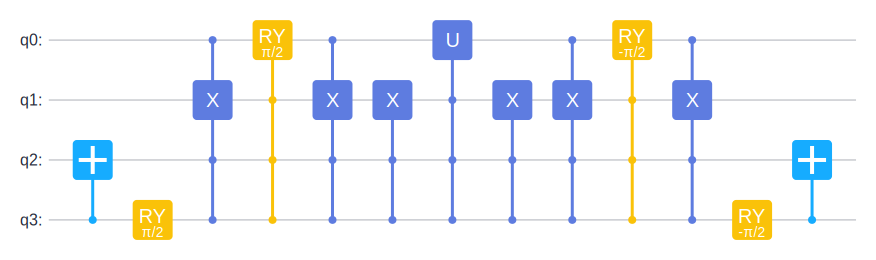

In [ ]:
# Qubit ansatz of qutrit controlled unitary gate
3 = 3
state = 1
ind = [0, 1]
U = unitary_group.rvs(2)
print(GCU(3, ind, U, state))

p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
GCUe = symmetric_encoding(GCU(3, ind, U, state), 2)
GCUp = GCUe + p
# print(GCUp)

circ = Circuit()
if state == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(
            1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
circ += UnivMathGate('U', U).on(0, [1, 2, 3])
circ += corr.hermitian()
# print(circ.matrix())
print(symmetric_decoding(circ.matrix() - p, 2))
print(np.allclose(GCUp, circ.matrix()))
circ.svg()

[[1.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  1.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  1.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.       +0.j  0.8660254+0.j  0.       -0.5j 0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.       +0.j  0.       -0.5j 0.8660254+0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  1.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j  1.       +0.j  0.       +0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  0.

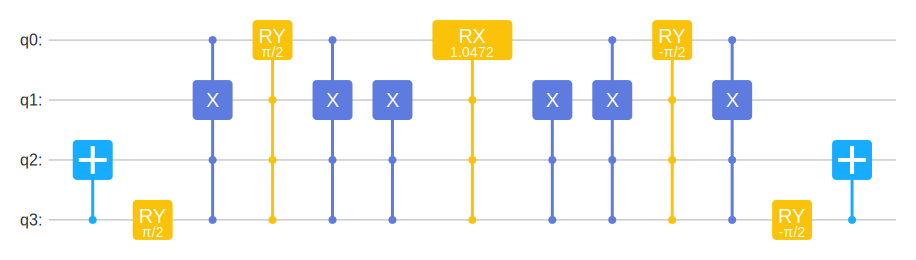

In [ ]:
# Qubit ansatz of qutrit controlled rotation gate
3 = 3
state = 1
name = 'X'
ind = [0, 1]
t = np.pi / 3
# print(GCR(name, d, ind, t, m))

p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
GCRe = symmetric_encoding(GCR(name, 3, ind, t, state), 2)
GCRp = GCRe + p
# print(GCRp)

circ = Circuit()
if state == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(
            1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
if name == 'X':
    circ = circ + RX(t).on(0, [1, 2, 3])
elif name == 'Y':
    circ = circ + RY(t).on(0, [1, 2, 3])
elif name == 'Z':
    circ = circ + RZ(t).on(0, [1, 2, 3])
circ += corr.hermitian()
# print(circ.matrix())
print(symmetric_decoding(circ.matrix() - p, 2))
print(np.allclose(GCRp, circ.matrix()))
circ.svg()

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.

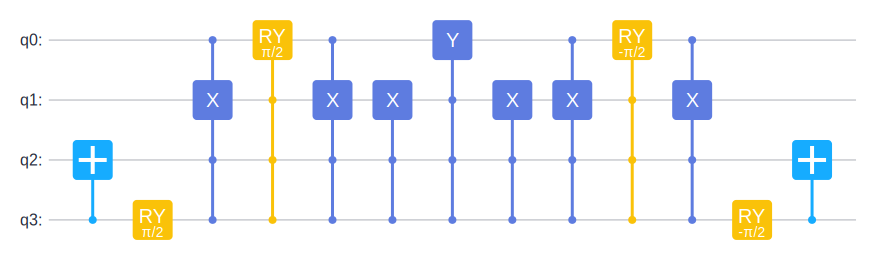

In [ ]:
# Qubit ansatz of qutrit controlled Pauli gate
3 = 3
state = 1
name = 'Y'
ind = [0, 1]
print(GCP(name, 3, ind, state))

p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
GCPe = symmetric_encoding(GCP(name, 3, ind, state), 2)
GCPp = GCPe + p
# print(GCPp)

circ = Circuit()
if state == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif state == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
if name == 'X':
    circ = circ + X(0, [1, 2, 3])
elif name == 'Y':
    circ = circ + Y(0, [1, 2, 3])
elif name == 'Z':
    circ = circ + Z(0, [1, 2, 3])
circ += corr.hermitian()
# print(circ.matrix())
print(symmetric_decoding(circ.matrix() - p, 2))
print(np.allclose(GCPp, circ.matrix()))
circ.svg()

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.       

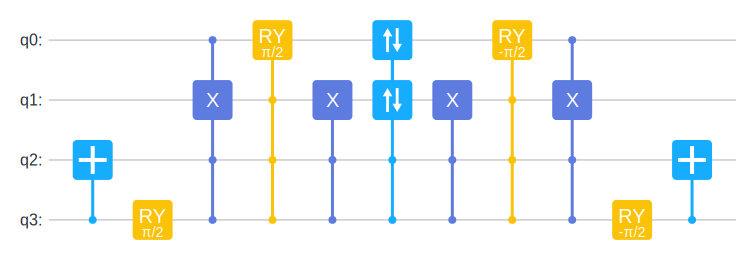

In [ ]:
# Qubit ansatz of qutrit GCX gate
3 = 3
state = 1
ind = [0, 1]
print(GCX(3, ind, state).real)

p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
GCXe = symmetric_encoding(GCX(3, ind, state), 2)
GCXp = GCXe + p
# print(GCXp.real)

circ = Circuit()
if state == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
elif state == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
elif state == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
circ += corr
circ = circ + SWAP([0, 1], [2, 3])
circ += corr.hermitian()
print(circ.matrix().real)
print(symmetric_decoding(circ.matrix() - p, 2).real)
print(np.allclose(GCXp, circ.matrix()))
circ.svg()

[[-0.18997645+0.22909415j  0.        +0.j         -0.19780133-0.93396973j]
 [ 0.        +0.j          1.        +0.j          0.        +0.j        ]
 [-0.78210049-0.54748848j  0.        +0.j         -0.28516435+0.08518494j]]
[[-0.18997645+0.22909415j  0.        +0.j          0.        +0.j         -0.19780133-0.93396973j]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j        ]
 [-0.78210049-0.54748848j  0.        +0.j          0.        +0.j         -0.28516435+0.08518494j]]
[[-0.18997645+0.22909415j  0.        +0.j          0.        +0.j         -0.19780133-0.93396973j]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j        ]
 [-0.78210049-0.54748848j  0.        +0.j          0.        +0.j         -0.285

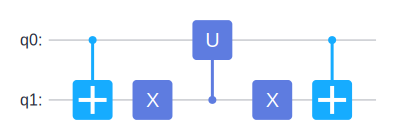

In [ ]:
# Qubit ansatz of one-qutrit unitary gate
3 = 3
ind = [0, 2]
U = unitary_group.rvs(2)
Ud = np.eye(3, dtype=CDTYPE)
Ud[np.ix_(ind, ind)] = U
print(Ud)

p = np.eye(2**(3 - 1)) - symmetric_encoding(np.eye(3))
Ue = symmetric_encoding(Ud)
Up = Ue + p
print(Up)

circ = Circuit()
if ind == [0, 1]:
    corr = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(1)
    corr = Circuit() + X(0, 1) + X(1) + RY(np.pi / 2).on(1, 0)
    corr = Circuit() + X(0, 1) + RY(-np.pi / 2).on(1, 0) + X(1)
elif ind == [0, 2]:
    corr = Circuit() + X(0) + X(1, 0) + X(0)
    corr = Circuit() + X(1) + X(1, 0)
    corr = Circuit() + X(1, 0) + X(1)
elif ind == [1, 2]:
    corr = Circuit() + X(1, 0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
    corr = Circuit() + X(0, 1) + RY(np.pi / 2).on(1, 0) + X(0, 1)
    corr = Circuit() + X(0, 1) + RY(np.pi / 2).on(1, 0) + X(0)
circ += corr
circ += UnivMathGate('U', U).on(0, 1)
circ += corr.hermitian()
print(circ.matrix())
# print(symmetric_decoding(circ.matrix() - p))
print(np.allclose(Up, circ.matrix()))
circ.svg()

[[0.8660254+0.j  0.       -0.5j 0.       +0.j ]
 [0.       -0.5j 0.8660254+0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  1.       +0.j ]]
[[ 0.8660254+0.j          0.       -0.35355339j  0.       -0.35355339j  0.       +0.j        ]
 [ 0.       -0.35355339j  0.9330127+0.j         -0.0669873+0.j          0.       +0.j        ]
 [ 0.       -0.35355339j -0.0669873+0.j          0.9330127+0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j        ]]
[[ 0.8660254+0.j          0.       -0.35355339j  0.       -0.35355339j  0.       +0.j        ]
 [ 0.       -0.35355339j  0.9330127+0.j         -0.0669873+0.j          0.       +0.j        ]
 [ 0.       -0.35355339j -0.0669873+0.j          0.9330127+0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j        ]]
[[0.8660254+0.j  0.       -0.5j 0.       +0.j ]
 [0.       -0.5j 0.8660254+0.j  0.       +0.j

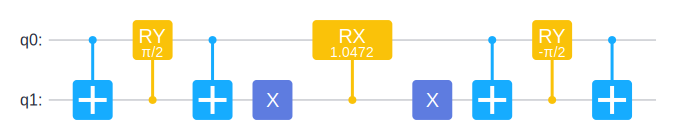

In [ ]:
# Qubit ansatz of one-qutrit unitary gate
3 = 3
name = 'X'
ind = [0, 1]
pr = np.pi / 3
print(Rd(name, 3, ind, pr))

p = np.eye(2**(3 - 1)) - symmetric_encoding(np.eye(3))
Re = symmetric_encoding(Rd(name, 3, ind, pr))
Rp = Re + p
print(Rp)

circ = Circuit()
if ind == [0, 1]:
    corr = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(1)
elif ind == [0, 2]:
    corr = Circuit() + X(0) + X(1, 0) + X(0)
elif ind == [1, 2]:
    corr = Circuit() + X(1, 0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
circ += corr
if name == 'X':
    circ = circ + RX(pr).on(0, 1)
elif name == 'Y':
    circ = circ + RY(pr).on(0, 1)
elif name == 'Z':
    circ = circ + RZ(pr).on(0, 1)
circ += corr.hermitian()
print(circ.matrix())
print(symmetric_decoding(circ.matrix() - p))
print(np.allclose(Rp, circ.matrix()))
circ.svg()

[[0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.5       +0.j -0.5       +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.5       +0.j  0.5       +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.5       +0.j -0.5       +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.5       +0.j  0.5       +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]]
[[ 0.0000000e+00+0.j  0.0000000e+00+0.j  1.0000000e+00+0.j]
 [ 1.0000000e+00+0.j -4.4408921e-16+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  1.0000000e+00+0.j  0.0000000e+00+0.j]]
True


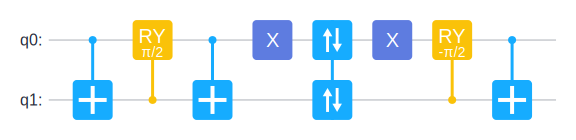

In [ ]:
# Qubit ansatz of qutrit INC gate
3 = 3
p = np.eye(2**(3 - 1)) - symmetric_encoding(np.eye(3))
q = {i: np.eye(3)[i] for i in range(3)}

state = q[0] + q[1]
state /= norm(state)
# str_ket(state, d)
# str_ket(INC @ state, d)
print(INC(3))

INCe = symmetric_encoding(INC(3))
INCp = INCe + p
# print(INCe)
print(INCp)
# str_ket(symmetric_encoding(state))
# str_ket(INCp @ symmetric_encoding(state))

circ = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(0) + SWAP([0, 1]) + X(0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
print(circ.matrix())
print(symmetric_decoding(circ.matrix() - p))
print(np.allclose(INCp, circ.matrix()))
circ.svg()

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.       

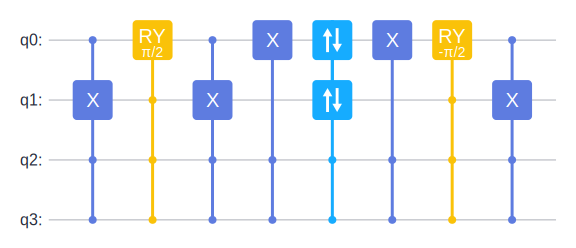

In [ ]:
# Qubit ansatz of qutrit CINC gate
3 = 3
print(CINC(3).real)

p = np.eye(2**((3 - 1) * 2)) - symmetric_encoding(np.eye(3**2), 2)
CINCe = symmetric_encoding(CINC(3), 2)
CINCp = CINCe + p
# print(CINCp.real)
circ = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
circ += SWAP([0, 1], [2, 3])
circ = circ + X(0, [2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
print(circ.matrix().real)
# print(symmetric_decoding(circ.matrix() - p, 2))
print(np.allclose(CINCp, circ.matrix()))
circ.svg()

In [ ]:
3, state = 3, 2
nqd = (3 - 1) * state
n = 2**nqd
symmetric_index(3, 2)

ind_ = {}
for i in range(2**(3 - 1)):
    num1 = bin(i).count('1')
    i_ = bin(i)[2:].zfill(3 - 1)
    if num1 in ind_:
        ind_[num1].append(i_)
    else:
        ind_[num1] = [i_]
for i in range(3**state):
    multi = ['']
    base = np.base_repr(i, 3).zfill(state)
    for j in range(state):
        multi = [x + y for x in multi for y in ind_[int(base[j])]]
    print(f'{i}|{base}⟩ -> ', end='')
    for j in multi:
        print(f'|{j}⟩ ', end='')
        # print(f'{int(j, 2)}|{j}⟩ ', end='')
    print()

0|00⟩ -> |0000⟩ 
1|01⟩ -> |0001⟩ |0010⟩ 
2|02⟩ -> |0011⟩ 
3|10⟩ -> |0100⟩ |1000⟩ 
4|11⟩ -> |0101⟩ |0110⟩ |1001⟩ |1010⟩ 
5|12⟩ -> |0111⟩ |1011⟩ 
6|20⟩ -> |1100⟩ 
7|21⟩ -> |1101⟩ |1110⟩ 
8|22⟩ -> |1111⟩ 


In [ ]:
# Qudit
3 = 3
nqd = 3 - 1
n = 2**nqd
for i in range(3):
    for j in range(3):
        a = f'a{str(i)}{str(j)}|{str(i)}⟩⟨{str(j)}|'
        print(a, end=' ')
    print()
print()
# Qubit
for i in range(n):
    for j in range(n):
        ii = bin(i)[2:].zfill(nqd)
        jj = bin(j)[2:].zfill(nqd)
        a = f'a{str(i)}{str(j)}|{ii}⟩⟨{jj}|'
        print(a, end=' ')
    print()

a00|0⟩⟨0| a01|0⟩⟨1| a02|0⟩⟨2| 
a10|1⟩⟨0| a11|1⟩⟨1| a12|1⟩⟨2| 
a20|2⟩⟨0| a21|2⟩⟨1| a22|2⟩⟨2| 

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [ ]:
# Qudit
3 = 4
nqd = 3 - 1
n = 2**nqd
print('\\begin{pmatrix}')
for i in range(3):
    for j in range(3):
        a = f'a_{{{str(i)}{str(j)}}}'
        if j < 3 - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')
print()
# Qubit
ind = {}
for i in range(n):
    num1 = bin(i).count('1')
    ind[i] = [num1]
print(ind)
print('\\begin{pmatrix}')
for i in range(3):
    for j in range(3):
        a = f'a_{{{str(ind[i][0])}{str(ind[j][0])}}}'
        if j < 3 - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')

\begin{pmatrix}
a_{00} & a_{01} & a_{02} & a_{03} \\
a_{10} & a_{11} & a_{12} & a_{13} \\
a_{20} & a_{21} & a_{22} & a_{23} \\
a_{30} & a_{31} & a_{32} & a_{33} \\
\end{pmatrix}

{0: [0], 1: [1], 2: [1], 3: [2], 4: [1], 5: [2], 6: [2], 7: [3]}
\begin{pmatrix}
a_{00} & a_{01} & a_{01} & a_{02} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{20} & a_{21} & a_{21} & a_{22} \\
\end{pmatrix}


In [ ]:
3 = 3
n = 2**(3 - 1)
a1 = unitary_group.rvs(3)
a2 = symmetric_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - symmetric_encoding(np.eye(3))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.70294006+0.03118885j  0.07149122-0.03163382j -0.32562695+0.62670402j]
 [-0.58979256-0.32180129j -0.08381644+0.28570668j -0.52579407+0.4283407j ]
 [ 0.1075851 -0.20473555j  0.82823819+0.46824812j -0.03587238-0.19996792j]]
[[ 0.70294006+0.03118885j  0.05055192-0.02236849j  0.05055192-0.02236849j -0.32562695+0.62670402j]
 [-0.41704632-0.22754787j -0.04190822+0.14285334j -0.04190822+0.14285334j -0.37179255+0.30288261j]
 [-0.41704632-0.22754787j -0.04190822+0.14285334j -0.04190822+0.14285334j -0.37179255+0.30288261j]
 [ 0.1075851 -0.20473555j  0.58565284+0.33110142j  0.58565284+0.33110142j -0.03587238-0.19996792j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [ ]:
3 = 3
n = 2**(3 - 1)
i1 = np.eye(3)
i2 = symmetric_encoding(i1)
p = np.eye(n) - symmetric_encoding(np.eye(3))
print(i1)
print(i2)
print(p)
is_symmetric(i2), matrix_rank(i2)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, 3)

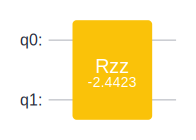

(True, True, True)

In [ ]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
3 = 3
a1 = unitary_group.rvs(3)
b1 = np.random.rand(3) + 1j * np.random.rand(3)
b1 /= norm(b1)
a2 = symmetric_encoding(a1)
b2 = symmetric_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [ ]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034-4.71109104e-18j 0.40977999+2.43349593e-01j]
 [0.40977999-2.43349593e-01j 0.65119966-1.91180564e-17j]]
[[0.03454462+1.57127038e-19j 0.0930421 -1.57144687e-01j]
 [0.0930421 +1.57144687e-01j 0.96545538+5.22244966e-18j]]
[[ 1.20491735e-02-1.07936862e-19j  3.24531155e-02-5.48121201e-02j  1.41556919e-02+8.40641803e-03j  7.63678855e-02-4.17529910e-02j]
 [ 3.24531155e-02+5.48121201e-02j  3.36751167e-01-2.72675600e-18j -1.14305675e-04+8.70365046e-02j  3.95624296e-01+2.34943175e-01j]
 [ 1.41556919e-02-8.40641803e-03j -1.14305675e-04-8.70365046e-02j  2.24954416e-02-5.58104827e-19j  6.05889828e-02-1.02332567e-01j]
 [ 7.63678855e-02+4.17529910e-02j  3.95624296e-01-2.34943175e-01j  6.05889828e-02+1.02332567e-01j  6.28704218e-01-1.50567731e-17j]]
(1.0000000000000007-5.551115123125783e-17j)


1.0000000000000002